## Data

For data let’s use MNIST dataset. Pytorch vision module has an easy way to create training and test dataset for MNIST

In [30]:
from torchvision import datasets,transforms
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional
import numpy as np
from torch.optim import Adam

In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [15]:
BATCH_SIZE = 100
trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
train_generator = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())

test_generator = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

## Visualization
Before proceeding, let’s visualize some data. For that I am using torchvision.utils.make_grid which creates a grid from multiple images:

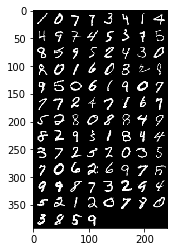

In [51]:
def show_images(images):
    images = make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

## Network Architecture
Similar to deniosing auto encoder, VAE has an encoder and decoder.

### Encoder
The encoder encodes an image to a varibale z with normal distribution. For normal distribution we just need to approximate mean m and standard deviation s. Therefore, the role of neural network is to learn a funcion from image to m and s. This implicitly means we are learning a function from image to a probability distribution for z. We implement that function approximator using linear matrix and RELU nonlinearity:

### Decoder
The decoder gets the encoded value z, which in theory is reffered to as latent variable, and decodes that value to an image. Therefore, the role of decoder is to learn a function that maps a value of z to a vector of 782 real values. Note that z is in fact a random variable but here we just work with a realization (a.k.a a sampled value) of that random variable

In [24]:
shape = images[0].shape

In [42]:
class VAE(nn.Module):
    def __init__(self,latent_variable_dim):
        super(VAE,self).__init__()
        
        ## encoder
        self.fc1 = nn.Linear(np.prod(shape),400)
        
        ## mean and std
        self.fc_mean = nn.Linear(400,latent_variable_dim)
        self.fc_std = nn.Linear(400, latent_variable_dim)
        
        ## decoder
        
        self.fc3 = nn.Linear(latent_variable_dim, 400)
        self.fc4 = nn.Linear(400, np.prod(shape))
        
    def reparameterize(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
    
    def decode(self,x):
        x = functional.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
    def forward(self,input):
        x = input.view(-1,784)
        x = functional.relu(self.fc1(x))
        log_s = self.fc_std(x)
        m = self.fc_mean(x)
        z = self.reparameterize(log_s,m)
        x = self.decode(z)
        
        return x,m,log_s

## Loss
For doing training we need a loss function. VAE combines two type of losses
- A loss from reconstructing the image. This is simply a Cross Entropy (CE) or Mean Square Error (MSE) between decoded image and original image
- KL divergence: this loss function is for latent variable $Z$,What we like to do is to make $P(z | input)$,as close as possible to standard normal (with mean zero and variance 1). Since $z$ has normal distribution with mean m and variance s. $z~N(m, s)$ we can use this simple formula to calculate the loss function of z.

In [43]:
def loss(input_image, recon_image, mu, log_var):
    CE = functional.binary_cross_entropy(recon_image, input_image.view(-1, np.prod(shape)), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return KLD + CE

## Train

In [46]:
vae = VAE(40)
optimizer = Adam(vae.parameters())
train_loss = []

for epoch in range(5):
    for i, data in enumerate(train_generator):
        images,labels = data
        images = images.to(device)
        optimizer.zero_grad()
        recon_image, s, mu = vae(images)
        l = loss(images, recon_image, mu, s)
        l.backward()
        train_loss.append(l.item() / len(images))
        optimizer.step()

In [53]:
from torchviz import make_dot

- **blue boxes**: these correspond to the tensors we use as parameters, the ones we’re asking PyTorch to compute gradients for;
- **gray box**: a Python operation that involves a gradient-computing tensor or its dependencies;
- **green box**: the same as the gray box, except it is the starting point for the computation of gradients (assuming the backward()method is called from the variable used to visualize the graph)— they are computed from the bottom-up in a graph.

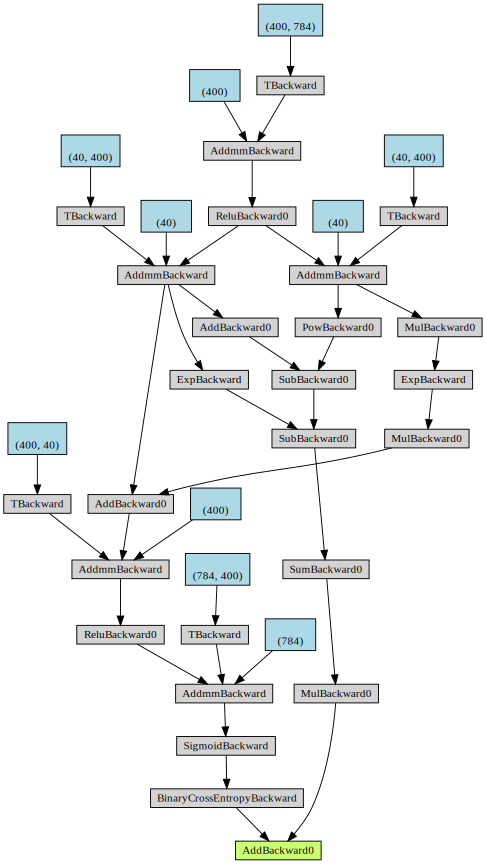

In [56]:
make_dot(l)

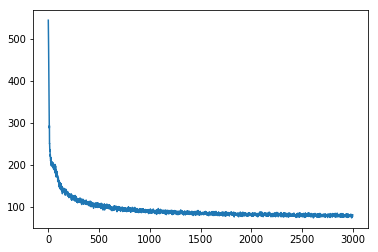

In [48]:
plt.plot(train_loss)

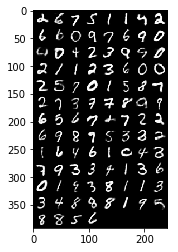

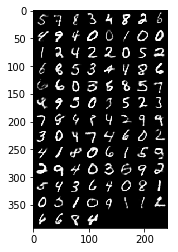

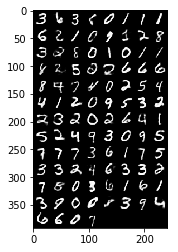

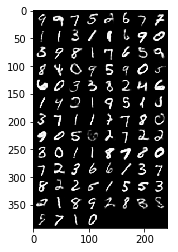

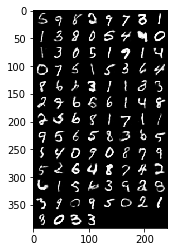

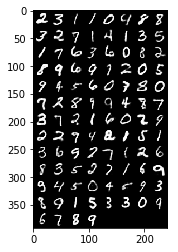

In [47]:
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        recon_image, s, mu = vae(images)
        recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)
        if i % 100 == 0:
            show_images(recon_image_)